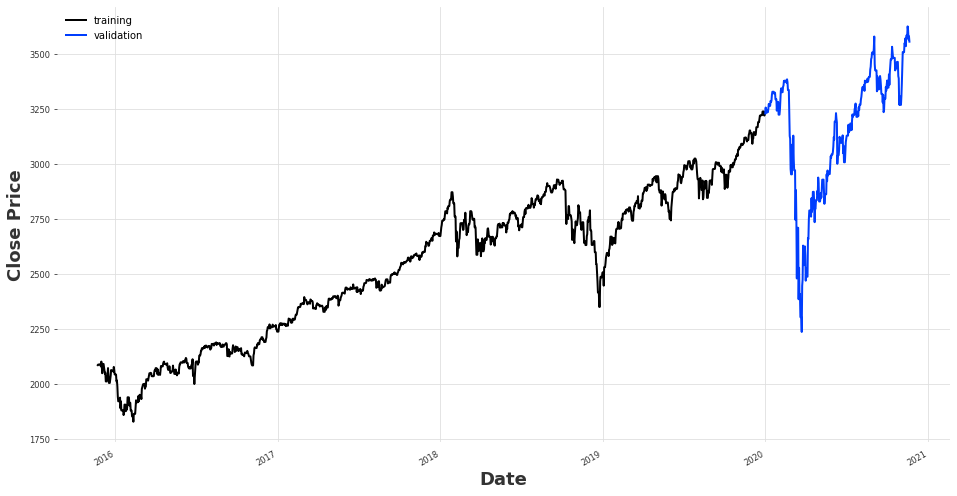

In [1]:
import pandas as pd
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.models import AutoARIMA
from darts.models import ARIMA
from darts.models import BlockRNNModel
import matplotlib.pyplot as plt

from darts.models import Prophet
from darts.metrics import mape

datasetName = "yahoo_stock.csv"
dataset = pd.read_csv(datasetName, sep=',')
dataset = dataset.drop(['Volume'], axis=1)


seriesClosed = TimeSeries.from_dataframe(dataset, 'Date', 'Close')
seriesOpen = TimeSeries.from_dataframe(dataset, 'Date', 'Open')
seriesHigh = TimeSeries.from_dataframe(dataset, 'Date', 'High')
seriesLow = TimeSeries.from_dataframe(dataset, 'Date', 'Low')
seriesAdjClosed = TimeSeries.from_dataframe(dataset, 'Date', 'Adj Close')

scalarClose, scalarOpen, scalarHigh, scalarLow, scalarAdjClosed = Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
ScSeriesClosed = scalarClose.fit_transform(seriesClosed)
ScSeriesOpen = scalarOpen.fit_transform(seriesOpen)
ScSeriesHigh = scalarHigh.fit_transform(seriesHigh)
ScSeriesLow = scalarLow.fit_transform(seriesLow)
ScSeriesAdjClosed = scalarAdjClosed.fit_transform(seriesAdjClosed)

splitDay = '2020-01-01'

trainClosed, valClosed = seriesClosed.split_before(pd.Timestamp(splitDay))

ScTrainClosed, ScValClosed = ScSeriesClosed.split_before(pd.Timestamp(splitDay))
ScTrainOpen, ScValOpen = ScSeriesOpen.split_before(pd.Timestamp(splitDay))
ScTrainHigh, ScValHigh = ScSeriesHigh.split_before(pd.Timestamp(splitDay))
ScTrainLow, ScValLow = ScSeriesLow.split_before(pd.Timestamp(splitDay))
ScTrainAdjClosed, ScValAdjClosed = ScSeriesAdjClosed.split_before(pd.Timestamp(splitDay))


plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
trainClosed.plot(label="training")
valClosed.plot(label="validation")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()




In [2]:
model_LSTM = BlockRNNModel(
    model='LSTM',
    input_chunk_length=120,
    output_chunk_length =10,
    n_epochs=100,
    random_state=0
)
model_LSTM.fit(series =[ScTrainClosed, ScTrainOpen, ScTrainHigh, ScTrainLow, ScTrainAdjClosed])



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=120, output_chunk_length=10, n_epochs=100, random_state=0)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

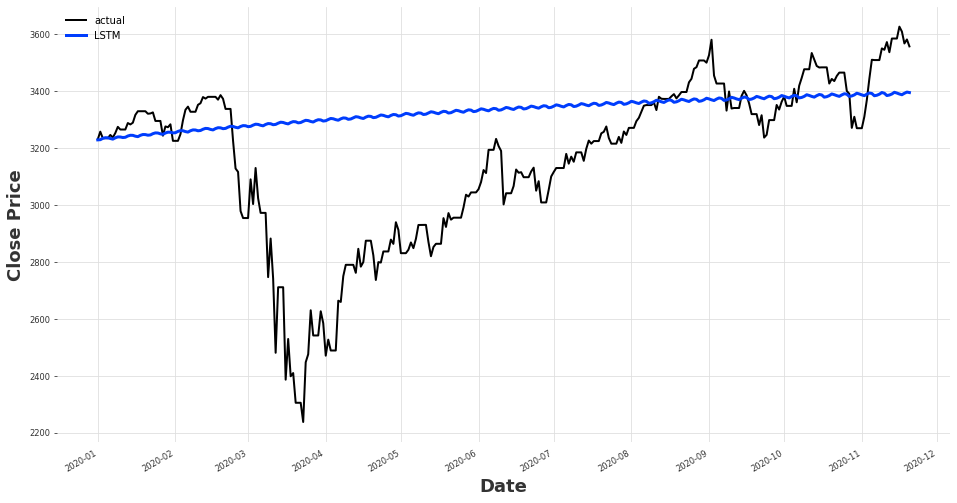

In [3]:
predictionLSTM = model_LSTM.predict(n=len(ScValClosed), series=ScTrainClosed)
predictionLSTM = scalarClose.inverse_transform(predictionLSTM)

plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
valClosed.plot(label='actual')
predictionLSTM.plot(label='LSTM', lw=3)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

10:34:37 - cmdstanpy - INFO - Chain [1] start processing
10:34:37 - cmdstanpy - INFO - Chain [1] done processing


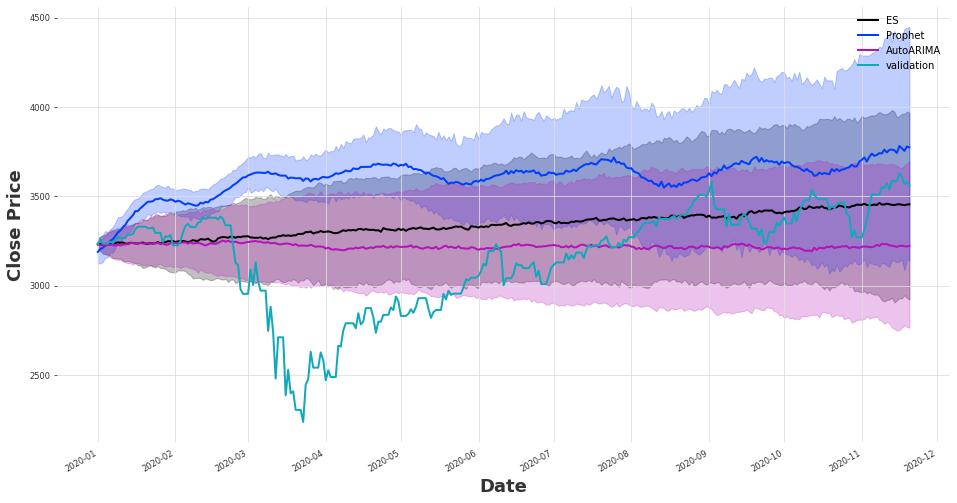

In [4]:
modelES = ExponentialSmoothing()
modelProphet = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
modelAutoARIMA = ARIMA()

modelES.fit(ScTrainClosed)
modelProphet.fit(ScTrainClosed)
modelAutoARIMA.fit(ScTrainClosed)

predictionES = modelES.predict(n=len(ScValClosed), num_samples = 200)
predictionProphet = modelProphet.predict(n=len(ScValClosed), num_samples = 200)
predictionAutoARIMA = modelAutoARIMA.predict(n=len(ScValClosed), num_samples = 200)

predictionES = scalarClose.inverse_transform(predictionES)
predictionProphet = scalarClose.inverse_transform(predictionProphet)
predictionAutoARIMA =scalarClose.inverse_transform(predictionAutoARIMA)

plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
predictionES.plot(label="ES")
predictionProphet.plot(label="Prophet")
predictionAutoARIMA.plot(label="AutoARIMA")
valClosed.plot(label="validation")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()


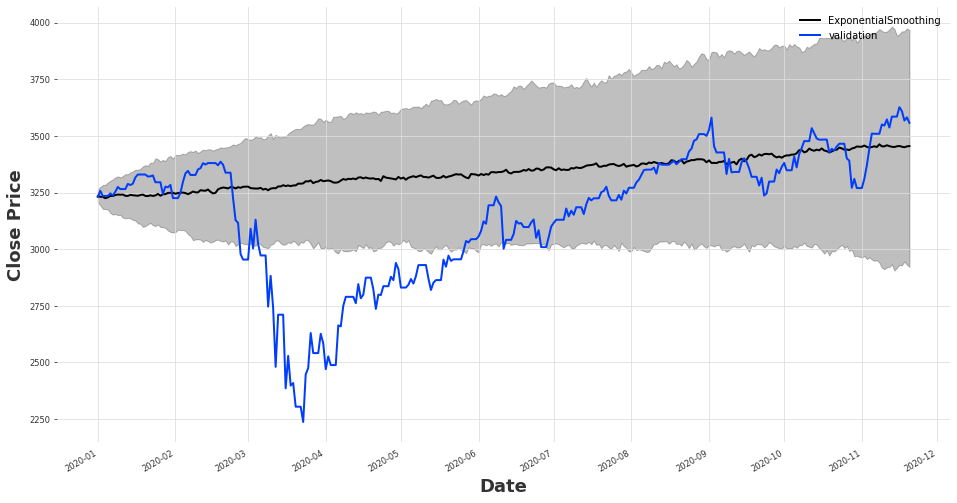

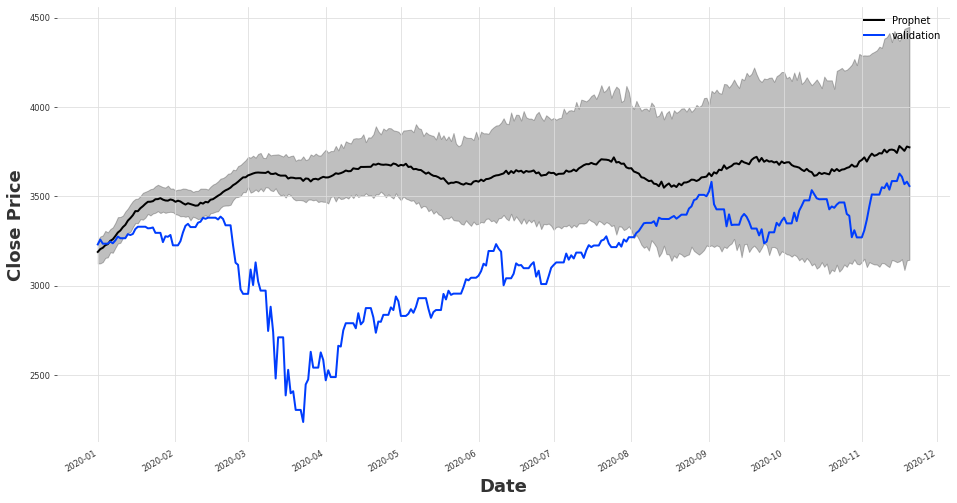

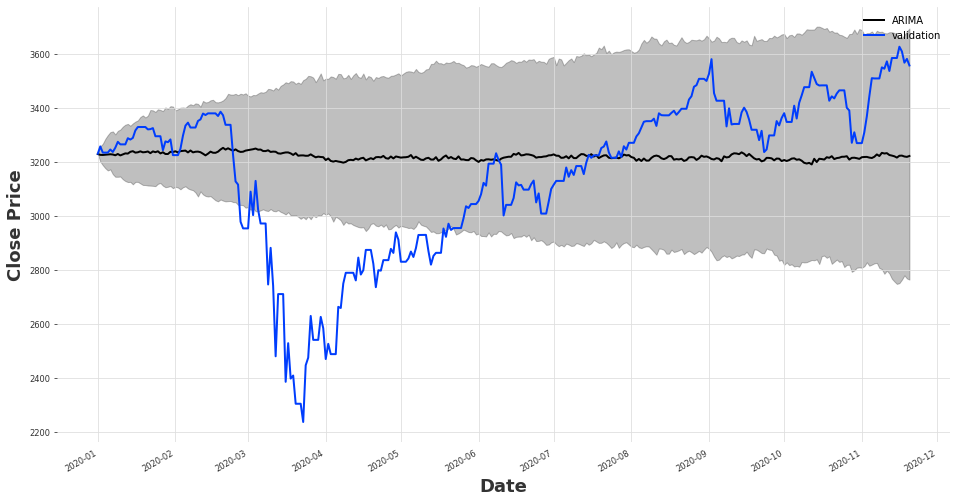

In [5]:
plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
predictionES.plot(label="ExponentialSmoothing")
valClosed.plot(label="validation")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
predictionProphet.plot(label="Prophet")
valClosed.plot(label="validation")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
predictionAutoARIMA.plot(label="ARIMA")
valClosed.plot(label="validation")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()


In [6]:
print("mape for LSTM:", mape(valClosed, predictionLSTM))
print("mape for ExponentialSmoothing:", mape(valClosed, predictionES))
print("mape for Prophet:", mape(valClosed, predictionProphet))
print("mape for ARIMA:", mape(valClosed, predictionAutoARIMA))

mape for LSTM: 7.91186976029377
mape for ExponentialSmoothing: 7.858864171231483
mape for Prophet: 15.217652561476381
mape for ARIMA: 7.582959929865036


2020-01-01

mape for LSTM: 7.91186976029377
mape for ExponentialSmoothing: 7.858864171231483
mape for Prophet: 15.217652561476381
mape for ARIMA: 7.582959929865036

ARIMA: Mean Absolute Percentage Error (MAPE): 7.60%
ETS: Mean Absolute Percentage Error (MAPE): 11.15%
Prophet: Mean Absolute Percentage Error (MAPE): 15.30%

2020-07-01

mape for LSTM: 12.934427033885296
mape for ExponentialSmoothing: 8.791280608164431
mape for Prophet: 11.830602009868114
mape for ARIMA: 9.06132713370662

ARIMA: Mean Absolute Percentage Error (MAPE): 7.72%
ETS: Mean Absolute Percentage Error (MAPE): 6.88%
Prophet: Mean Absolute Percentage Error (MAPE): 9.07%

2020-09-01
mape for LSTM: 21.81971093986891
mape for ExponentialSmoothing: 2.730606849183173
mape for Prophet: 7.724602993404756
mape for ARIMA: 2.5664100451513834

ARIMA: Mean Absolute Percentage Error (MAPE): 3.11%
ETS: Mean Absolute Percentage Error (MAPE): 5.88%
Prophet: Mean Absolute Percentage Error (MAPE): 2.47%

2020-10-01
mape for LSTM: 5.838308094866569
mape for ExponentialSmoothing: 3.2037278545615373
mape for Prophet: 6.307871604480976
mape for ARIMA: 3.2082107484632494

ARIMA: Mean Absolute Percentage Error (MAPE): 3.30%
ETS: Mean Absolute Percentage Error (MAPE): 2.97%
Prophet: Mean Absolute Percentage Error (MAPE): 2.43%


2020-11-01

mape for LSTM: 6.393745501359225
mape for ExponentialSmoothing: 6.855195774686528
mape for Prophet: 6.499908997262247
mape for ARIMA: 6.789119820592027

ARIMA: Mean Absolute Percentage Error (MAPE): 6.92%
ETS: Mean Absolute Percentage Error (MAPE): 6.69%
Prophet: Mean Absolute Percentage Error (MAPE): 2.96%



In [7]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA, ExponentialSmoothing, Prophet, RNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality
from pmdarima import auto_arima
from statsmodels.tsa.api import ExponentialSmoothing as ExponentialSmoothingSM

# Create a time series object
time_series = seriesClosed

splitDays = ['2020-01-01','2020-07-01','2020-09-01','2020-10-01','2020-11-01']

for splitDay in splitDays:
    print(splitDay)
    # Train/test split
    train, test = time_series.split_before(pd.Timestamp(splitDay))

    # Optimize ARIMA
    arima_model = auto_arima(train.pd_series(), suppress_warnings=True, seasonal=False, stepwise=True)
    p, d, q = arima_model.order


    # Create and fit the models
    models = {
        'ARIMA': ARIMA(p, d, q),
        'ETS': ExponentialSmoothing(),
        'Prophet': Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False),
    }


    for name, model in models.items():
        model.fit(train)
        
        forecast = model.predict(len(test))
        error = mape(test, forecast)
        print(f"{name}: Mean Absolute Percentage Error (MAPE): {error:.2f}%")

2020-01-01
ARIMA: Mean Absolute Percentage Error (MAPE): 7.60%
ETS: Mean Absolute Percentage Error (MAPE): 11.15%


10:34:55 - cmdstanpy - INFO - Chain [1] start processing
10:34:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet: Mean Absolute Percentage Error (MAPE): 15.30%
2020-07-01


c:\Users\basti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\basti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\basti\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: Mean Absolute Percentage Error (MAPE): 7.72%
ETS: Mean Absolute Percentage Error (MAPE): 6.88%


10:35:27 - cmdstanpy - INFO - Chain [1] start processing
10:35:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet: Mean Absolute Percentage Error (MAPE): 9.07%
2020-09-01
ARIMA: Mean Absolute Percentage Error (MAPE): 3.11%


10:35:38 - cmdstanpy - INFO - Chain [1] start processing


ETS: Mean Absolute Percentage Error (MAPE): 5.88%


10:35:39 - cmdstanpy - INFO - Chain [1] done processing


Prophet: Mean Absolute Percentage Error (MAPE): 2.47%
2020-10-01
ARIMA: Mean Absolute Percentage Error (MAPE): 3.30%
ETS: Mean Absolute Percentage Error (MAPE): 2.97%


10:36:00 - cmdstanpy - INFO - Chain [1] start processing
10:36:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet: Mean Absolute Percentage Error (MAPE): 2.43%
2020-11-01
ARIMA: Mean Absolute Percentage Error (MAPE): 6.92%
ETS: Mean Absolute Percentage Error (MAPE): 6.69%


10:36:24 - cmdstanpy - INFO - Chain [1] start processing
10:36:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet: Mean Absolute Percentage Error (MAPE): 2.96%


2020-09-01
ARIMA: Mean Absolute Percentage Error (MAPE): 3.11%


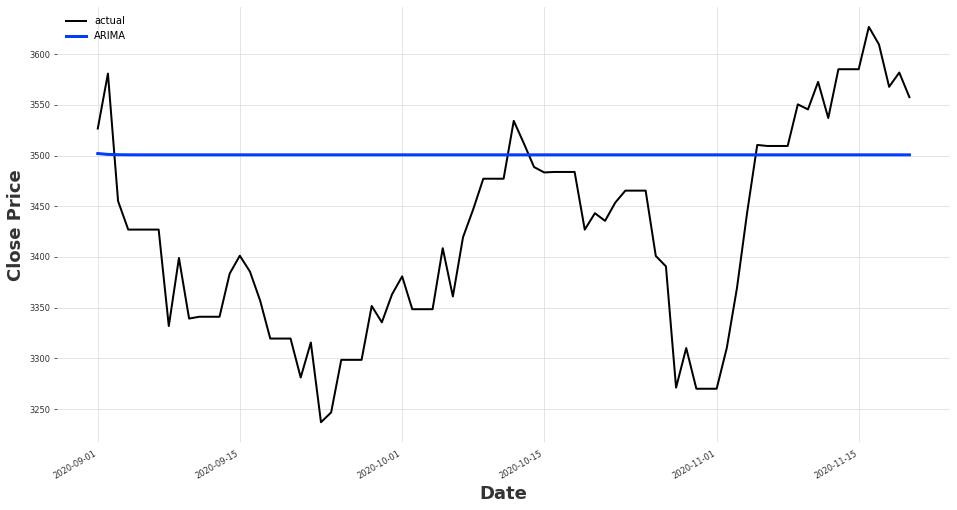

ETS: Mean Absolute Percentage Error (MAPE): 5.88%


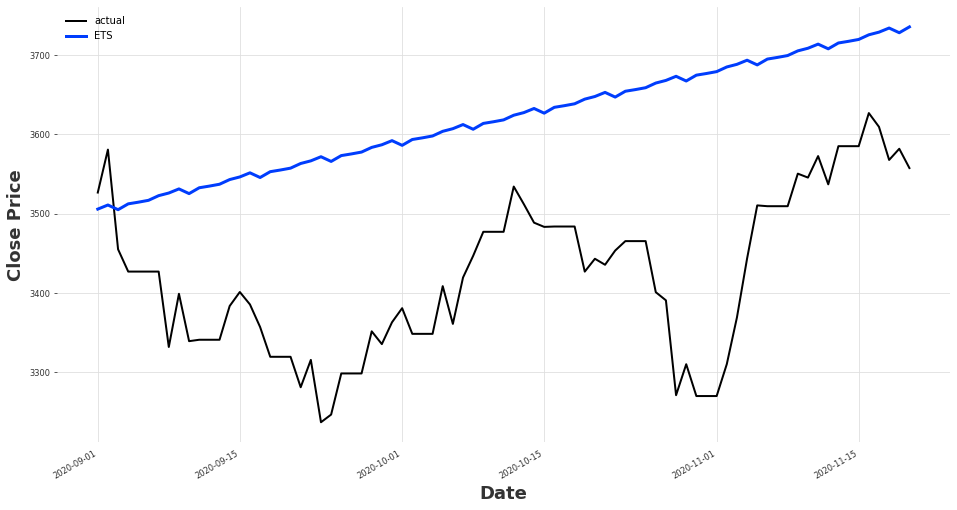

10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet: Mean Absolute Percentage Error (MAPE): 2.47%


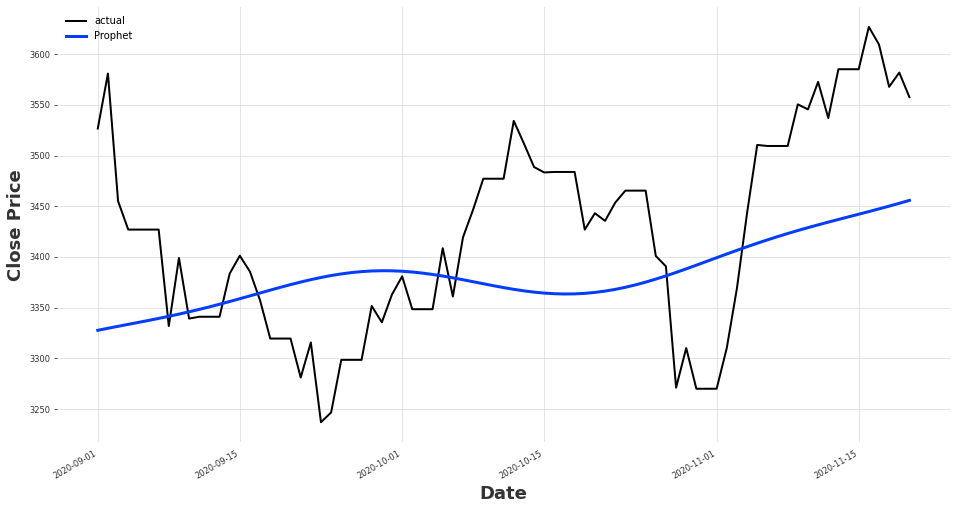

2020-10-01
ARIMA: Mean Absolute Percentage Error (MAPE): 3.30%


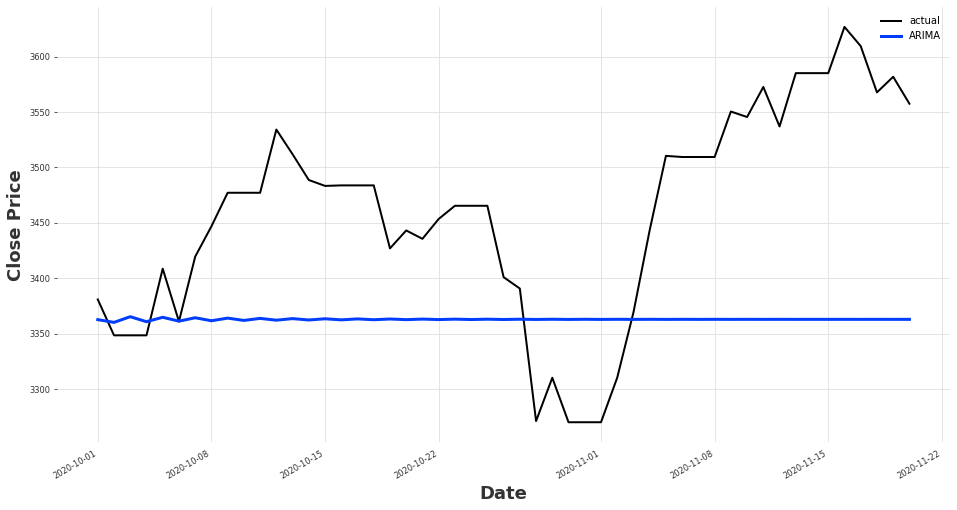

ETS: Mean Absolute Percentage Error (MAPE): 2.97%


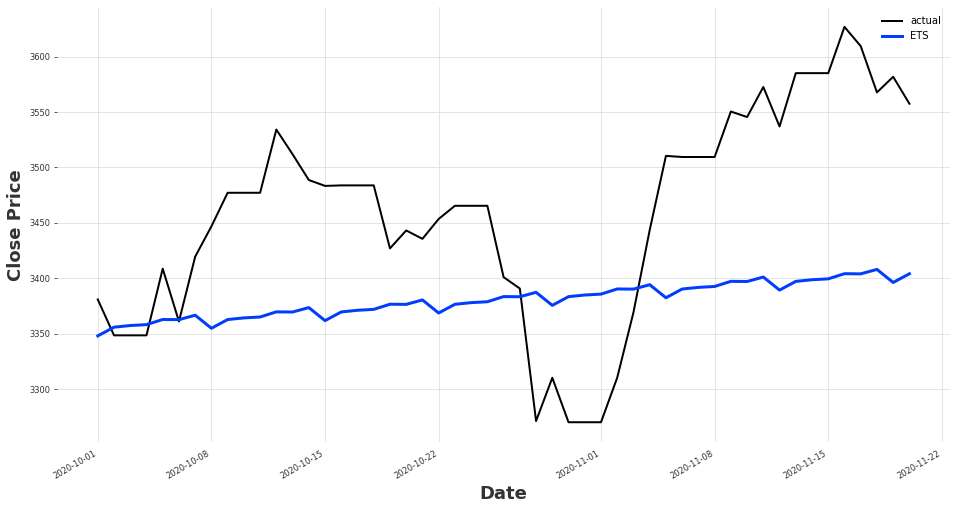

10:36:57 - cmdstanpy - INFO - Chain [1] start processing
10:36:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet: Mean Absolute Percentage Error (MAPE): 2.43%


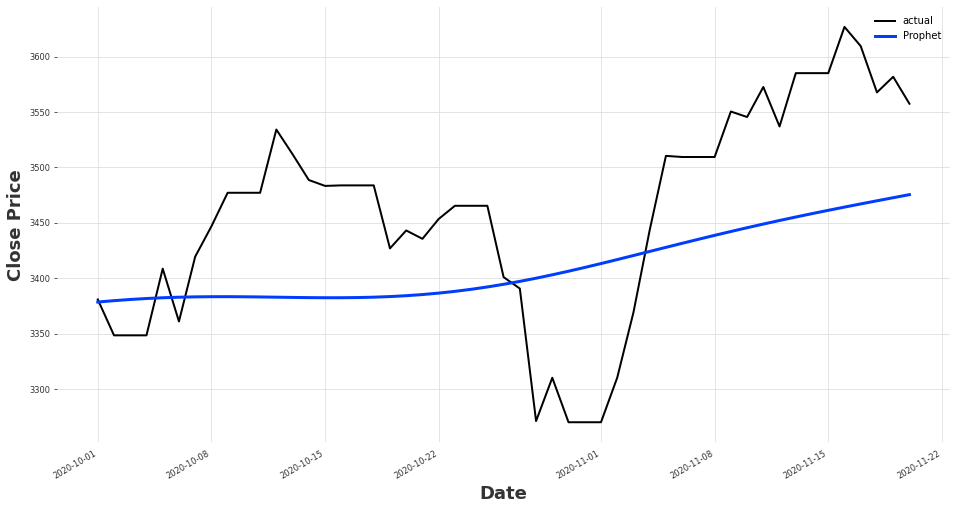

In [8]:
splitDays = ['2020-09-01','2020-10-01']

for splitDay in splitDays:
    print(splitDay)
    # Train/test split
    train, test = time_series.split_before(pd.Timestamp(splitDay))

    # Optimize ARIMA
    arima_model = auto_arima(train.pd_series(), suppress_warnings=True, seasonal=False, stepwise=True)
    p, d, q = arima_model.order


    # Create and fit the models
    models = {
        'ARIMA': ARIMA(p, d, q),
        'ETS': ExponentialSmoothing(),
        'Prophet': Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False),
    }


    for name, model in models.items():
        model.fit(train)
        
        forecast = model.predict(len(test))
        error = mape(test, forecast)
        print(f"{name}: Mean Absolute Percentage Error (MAPE): {error:.2f}%")

        plt.figure(figsize=(16,8))
        plt.title('Yahoo Stock Price Prediction')
        test.plot(label='actual')
        forecast.plot(label=name, lw=3)
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price', fontsize=18)
        plt.legend()
        plt.show()



        

    

